# Final Project Submission
Please fill out:

* Student name: Christopher Hollman
* Student pace: Self paced 
* Scheduled review date/time:
* Instructor name: Abhineet Kulkarni
* Blog post URL: 

## Buisiness Problem/Project Overview
An online publication group would like to use twitter data as a tool to help inform their writers as to which subjects are of interest among users. The goal of this model is to classify the overall sentiment of individual tweets and determine which words are most commonly used within those categories. The resulting visualizations should help writers narrow down their research, enabling them to more efficiently produce content that will generate interest and focus on the most relevent subjects. This project is meant to be a proof of concept centered around the 2012 SXSW conference, specifically tweets about Google and Apple who both tend to have a huge presence at the event. Typically this consists releasing new products, hosting events, and inviting guest speakers.  

In [1099]:
#importing relevent libraries

import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk import FreqDist 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report


In [1107]:
data=pd.read_csv("Data/tweet_data.csv", encoding="latin-1") 
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


## Initial Data Exploration

In [1108]:
#These column names, while very descriptive, need to be more user friendly
data = data.rename(columns = {'tweet_text':'text',
                              'emotion_in_tweet_is_directed_at':'product',
                              'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})

In [1109]:
data['product'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [1110]:
#For our purposes we will just look at brands, as our focus is on brand presence at sxsw
prod_replace_dict = {                     
                     'iPhone':'Apple',
                     'iPad':'Apple',
                     'iPad or iPhone App':'Apple',
                     'Other Apple product or service':'Apple',
                     'Android':'Google',
                     'Android App':'Google',
                     'Other Google product or service':'Google'
}

sent_replace_dict = {
                     'No emotion toward brand or product':'No Emotion',
                     'Positive emotion':'Positive',
                     'Negative emotion':'Negative'
}

In [1111]:
data['product'] = data['product'].replace(prod_replace_dict)
data['sentiment'] = data['sentiment'].replace(sent_replace_dict)
data.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


### Distributions

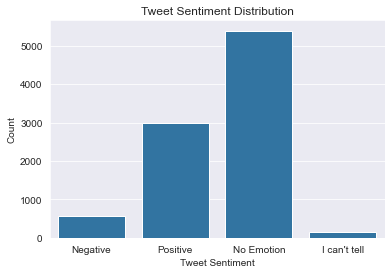

In [1112]:
fig, ax = plt.subplots()

sns.countplot(x=data['sentiment'], data = data, color='tab:blue')

ax.set(
    xlabel='Tweet Sentiment', ylabel='Count', title='Tweet Sentiment Distribution'
);

The vest majority of tweets overall convey a neutral emotion. We will need to address class imbalance once we start modeling the data. 

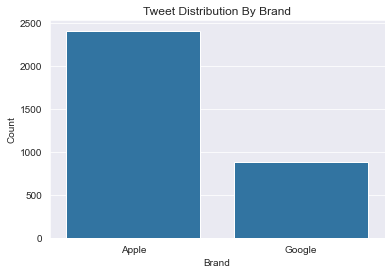

In [1113]:
fig, ax = plt.subplots()

classes = ['Apple', 'Google']
sns.countplot(x=data['product'], data = data, color='tab:blue', order=classes)

ax.set(xticklabels=['Apple', 'Google'], 
       xlabel='Brand', ylabel='Count', title='Tweet Distribution By Brand');

It also appears that Apple generated more interest than google at this particular event. 

In [1114]:
data.isna().sum()
#Over half of the tweets in this dataset aren't directed at a given product or brand.

text            1
product      5802
sentiment       0
dtype: int64

In [1115]:
data[data['product'].isnull()]
#We can see that some of these tweets may pertain to our business problem. We will leave them alone for now.

,text,product,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No Emotion
6,NaN,NaN,No Emotion
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No Emotion
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No Emotion
33,Anyone at #sxsw want to sell their old iPad?,NaN,No Emotion
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No Emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No Emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No Emotion
9091,Some Verizon iPhone customers complained their...,NaN,No Emotion


In [1116]:
#We can drop the single NaN value in the text column
data.dropna(subset=['text'], inplace = True)
data.reset_index(drop=True, inplace=True)

In [1117]:
data = data[data['sentiment'] != "I can't tell"]
data['sentiment'].value_counts()
#With so few "I can't tell" values, it doesnt make sense to classify them
#With such a large class imbalance, it makes sense to stratify our train and test sets

No Emotion    5388
Positive      2978
Negative       570
Name: sentiment, dtype: int64

## Basic Data Vizualization

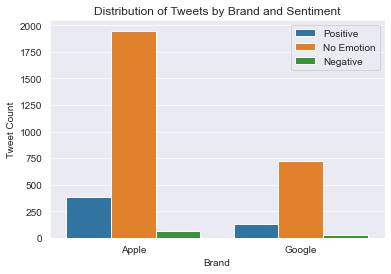

In [1118]:
fig, ax = plt.subplots()
sns.countplot(x='product', data=data, hue='sentiment')

ax.set(title='Distribution of Tweets by Brand and Sentiment', 
       xticklabels=['Apple', 'Google'], 
       xlabel='Brand', ylabel='Tweet Count')
ax.legend(['Positive', 'No Emotion', 'Negative'])

plt.show()


As we discovered earlier, Apple did generate more tweets that Google, however distributions of positive to negative tweets seem consistent between the two brands. No emotion remains the most common sentiment. 

## Data Cleaning
We will be able to develop more useful visualizations after we clean up our tweets a little bit. In this section we will remove twitter handles, standardize case, remove punctuation, and tokenize for initial analysis.  

In [1119]:
#train test split to avoid data leakage 

X = data.drop('sentiment', axis=1)
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

In [1120]:
#standardizing case
X_train['text'] = X_train['text'].str.lower()
X_test['text'] = X_test['text'].str.lower()

In [1121]:
train_text = X_train['text']
test_text = X_test['text']

train_text.head(10)

4555    is everyone that works at google this genius??...
3310    ipad design malady: ipad elbow - i hate the ip...
3065    in the press lounge of #sxsw, someone is getti...
237     audioboo: american dream or bust {link} #ipad ...
7847    qrafter is better than all paid or free qr cod...
7562    congrats radical media, google, arcade fire fo...
8248    ad jg buat iphone rt @mention new #ubersocial ...
2348    @mention check out googletv to ipad apps: the ...
1636    google's @mention takes stage to talk on locat...
2818    i am amused at the apple pop-up store at #sxsw...
Name: text, dtype: object

In [1122]:
#This block of code should remove twitter handles for both data sets
for line in train_text:    
    new_line = re.sub(r'@([A-Za-z0-9_]+)','', line)
    train_text.replace(line, new_line, inplace=True)      
    
for line in test_text:
    new_line = re.sub(r'@([A-Za-z0-9_]+)','', line)
    train_text.replace(line, new_line, inplace=True)

In [1123]:
train_text.head(10)

4555    is everyone that works at google this genius??...
3310    ipad design malady: ipad elbow - i hate the ip...
3065    in the press lounge of #sxsw, someone is getti...
237     audioboo: american dream or bust {link} #ipad ...
7847    qrafter is better than all paid or free qr cod...
7562    congrats radical media, google, arcade fire fo...
8248    ad jg buat iphone rt  new #ubersocial for #iph...
2348     check out googletv to ipad apps: the connecte...
1636    google's  takes stage to talk on location, fut...
2818    i am amused at the apple pop-up store at #sxsw...
Name: text, dtype: object

In [1124]:
#removing punctuation

for line in train_text:
    new_line = line.translate(str.maketrans('', '', string.punctuation))
    train_text.replace(line, new_line, inplace=True)

for line in test_text:
    new_line = line.translate(str.maketrans('', '', string.punctuation))

In [1125]:
train_text

4555    is everyone that works at google this genius  ...
3310    ipad design malady ipad elbow  i hate the ipad...
3065    in the press lounge of sxsw someone is getting...
237     audioboo american dream or bust link ipad sxsw...
7847    qrafter is better than all paid or free qr cod...
                              ...                        
5754      rt  full sxsw touchingstories presentation link
4381    what are my seattle sxsw peeps up to today rep...
6616    rt  rt  walking into the popup apple store is ...
3176    at sxsw for demoing feedly at tomorrows androi...
1140    holy crap the sxsw 2011 showcase torrents are ...
Name: text, Length: 6702, dtype: object

In [1126]:
#using standard regex pattern to tokenize tweets 
from nltk.tokenize import RegexpTokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [1127]:
# Create new column with tokenized data
X_train['text_tokenized'] = train_text.apply(tokenizer.tokenize)
X_test['text_tokenized'] = test_text.apply(tokenizer.tokenize)
# Display full text
X_train['text_tokenized']

4555    [is, everyone, that, works, at, google, this, ...
3310    [ipad, design, malady, ipad, elbow, hate, the,...
3065    [in, the, press, lounge, of, sxsw, someone, is...
237     [audioboo, american, dream, or, bust, link, ip...
7847    [qrafter, is, better, than, all, paid, or, fre...
                              ...                        
5754    [rt, full, sxsw, touchingstories, presentation...
4381    [what, are, my, seattle, sxsw, peeps, up, to, ...
6616    [rt, rt, walking, into, the, popup, apple, sto...
3176    [at, sxsw, for, demoing, feedly, at, tomorrows...
1140    [holy, crap, the, sxsw, 2011, showcase, torren...
Name: text_tokenized, Length: 6702, dtype: object

# Processing
In this section we will take a look at word frequencies and make decisions on further processing such as removal of stopwords.

In [1128]:
def visualize_top_20(freq_dist, title):

    # Extract data for plotting
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    

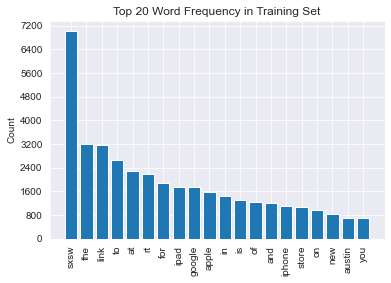

In [1129]:
X_train_freq_dist = FreqDist(X_train['text_tokenized'].explode())
visualize_top_20(X_train_freq_dist, "Top 20 Word Frequency in Training Set")

We can see here that many of our most commonly used words are stopwords

In [1130]:
stopwords_list = stopwords.words('english')

def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [1131]:
X_train['text_without_stopwords'] = X_train['text_tokenized'].apply(remove_stopwords)
X_test['text_without_stopwords'] = X_test['text_tokenized'].apply(remove_stopwords)

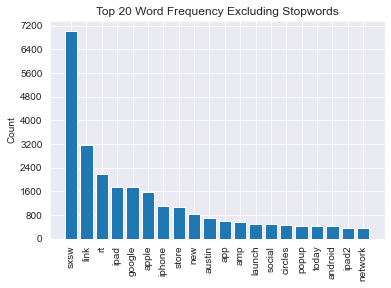

In [1132]:

# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["text_without_stopwords"].explode())

# Plot the top 20 tokens
visualize_top_20(train_freq_dist, "Top 20 Word Frequency Excluding Stopwords")

This is better, but many of these words are twitter characters (rt, link, amp, quot) or are specific to the conference (austin, sxsw) we should remove all of these.

In [1133]:
#these words are very common but don't tell us much about the tweet itself.
sxsw_list = ['sxsw', 'rt', 'link', 'quot', 'austin', 'amp']

def remove_sxsw(token_list):
    sxsw_removed = [token for token in token_list if token not in sxsw_list]
    return sxsw_removed

X_train["text_without_stopwords"] = X_train["text_without_stopwords"].apply(remove_sxsw)
X_test["text_without_stopwords"] = X_test["text_without_stopwords"].apply(remove_sxsw)

X_train['text_without_stopwords'].head()

4555    [everyone, works, google, genius, seriously, s...
3310    [ipad, design, malady, ipad, elbow, hate, ipad...
3065    [press, lounge, someone, getting, tutorial, us...
237     [audioboo, american, dream, bust, ipad, bum, b...
7847    [qrafter, better, paid, free, qr, code, apps, ...
Name: text_without_stopwords, dtype: object

In [1134]:
#we will both stem and lemmatize the words to see if these techniques improve our model accuracy.
stemmer = SnowballStemmer('english')
def stem_text(text):
    return [stemmer.stem(w) for w in text]

X_train['stemmed_text'] = X_train['text_without_stopwords'].apply(stem_text)

In [1135]:
#the next step is to lemmatize text to combine different tenses of some words   
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

X_train['lemmatized_text'] = X_train['text_without_stopwords'].apply(lemmatize_text)

## Secondary Data Visualization

Now that we have a clearer picture of the overall text content within the dataset, it is time develop examples of some of the visuals that will make up our end product.

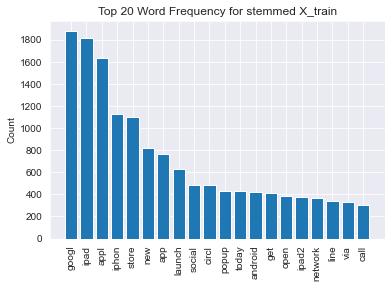

In [1136]:
# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train['stemmed_text'].explode())

# Plot the top 20 tokens
visualize_top_20(train_freq_dist, "Top 20 Word Frequency for stemmed X_train")

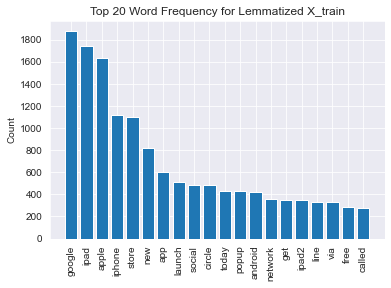

In [1137]:
# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["lemmatized_text"].explode())

# Plot the top 20 tokens
visualize_top_20(train_freq_dist, "Top 20 Word Frequency for Lemmatized X_train")

This is interesting, despite generating more 'buzz' than Google, Apple is the third most common word, as it's products are somewhat synonymous with the brand itself. Within our results, the top words are very similar between stemming and lemmatizing.

## World Clouds

Next we will generate word clouds separated by brand and sentiment.

In [1138]:
#We will use a copy of the training data to generate some word clouds
processed_data = X_train.copy()
processed_data['label'] = [y_train[idx] for idx in processed_data.index]

apple_df = processed_data[processed_data['product'] == 'Apple']
apple_pos_df = apple_df[apple_df['label'] == 'Positive']
apple_neg_df = apple_df[apple_df['label'] == 'Negative']

google_df = processed_data[processed_data['product'] == 'Google']
google_pos_df = google_df[google_df['label'] == 'Positive']
google_neg_df = google_df[google_df['label'] == 'Negative']

In [1139]:
#since results are similar, it makes sense to use lemmatized words rather than stemming for better readability.
apple_df['final_text'] = apple_df['lemmatized_text'].apply(lambda x: ' '.join(x))
google_df['final_text'] = google_df['lemmatized_text'].apply(lambda x: ' '.join(x))

In [1140]:
#separating out Apple specific positive and negative corpora
apple_positive = apple_df['final_text'].loc[apple_df['label']=='Positive'].tolist()
apple_positive = ' '.join(apple_positive)

apple_negative = apple_df['final_text'].loc[apple_df['label']=='Negative'].tolist()
apple_negative = ' '.join(apple_negative)

In [1141]:
#repeating the process for Google
google_positive = google_df['final_text'].loc[google_df['label']=='Positive'].tolist()
google_positive = ' '.join(google_positive)

google_negative = google_df['final_text'].loc[google_df['label']=='Negative'].tolist()
google_negative = ' '.join(google_negative)

### Postive Apple Tweets

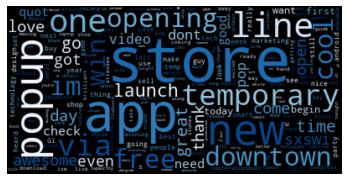

In [1142]:
#generating word cloud for positive apple tweets, excluding obvious words
wordcloud = WordCloud(collocations=False, colormap='Blues').generate(apple_positive.replace(
    'apple','').replace(
    'ipad','').replace(
    'iphone',''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

'Store' is an interesting word in this cloud, lets take a look at a few tweets than mention the word.

In [1143]:
apple_pos_df[apple_pos_df['text'].str.contains('store')].head(10)

,text,product,text_tokenized,text_without_stopwords,stemmed_text,lemmatized_text,label
2818,i am amused at the apple popup store at sxsw t...,Apple,"[am, amused, at, the, apple, popup, store, at,...","[amused, apple, popup, store, year, brilliant,...","[amus, appl, popup, store, year, brilliant, id...","[amused, apple, popup, store, year, brilliant,...",Positive
331,long line at apple pop up store for ipad 2 gre...,Apple,"[long, line, at, apple, pop, up, store, for, i...","[long, line, apple, pop, store, ipad, great, m...","[long, line, appl, pop, store, ipad, great, ma...","[long, line, apple, pop, store, ipad, great, m...",Positive
3533,just bought one of the last few ipads at the a...,Apple,"[just, bought, one, of, the, last, few, ipads,...","[bought, one, last, ipads, apple, store, downt...","[bought, one, last, ipad, appl, store, downtow...","[bought, one, last, ipads, apple, store, downt...",Positive
8437,line for the ipad 2 at the apple store no demo...,Apple,"[line, for, the, ipad, at, the, apple, store, ...","[line, ipad, apple, store, demo, units, 5pm, fb]","[line, ipad, appl, store, demo, unit, 5pm, fb]","[line, ipad, apple, store, demo, unit, 5pm, fb]",Positive
1732,fear not sxswers rt confirmed apple store 2 w...,Apple,"[fear, not, sxswers, rt, confirmed, apple, sto...","[fear, sxswers, confirmed, apple, store, week,...","[fear, sxswer, confirm, appl, store, week, popup]","[fear, sxswers, confirmed, apple, store, week,...",Positive
2153,the line at the popup apple store is phenomena...,Apple,"[the, line, at, the, popup, apple, store, is, ...","[line, popup, apple, store, phenomenal, apple,...","[line, popup, appl, store, phenomen, appl, ipad2]","[line, popup, apple, store, phenomenal, apple,...",Positive
4647,nice work on organizing the apple popup store...,Apple,"[nice, work, on, organizing, the, apple, popup...","[nice, work, organizing, apple, popup, store, ...","[nice, work, organ, appl, popup, store, wish]","[nice, work, organizing, apple, popup, store, ...",Positive
1839,its not a rumor apple is opening up a temporar...,Apple,"[its, not, rumor, apple, is, opening, up, temp...","[rumor, apple, opening, temporary, store, down...","[rumor, appl, open, temporari, store, downtown...","[rumor, apple, opening, temporary, store, down...",Positive
1055,love it rt from apple to naomi campbell popu...,Apple,"[love, it, rt, from, apple, to, naomi, campbel...","[love, apple, naomi, campbell, popup, stores, ...","[love, appl, naomi, campbel, popup, store, rage]","[love, apple, naomi, campbell, popup, store, r...",Positive
2620,which line at sxsw will be longer 311 at the t...,Apple,"[which, line, at, sxsw, will, be, longer, 311,...","[line, longer, 311, temp, apple, store, ipad2,...","[line, longer, 311, temp, appl, store, ipad2, ...","[line, longer, 311, temp, apple, store, ipad2,...",Positive


In [1144]:
print(apple_pos_df.loc[6417, 'text'])

rt  ooooo apple rumored to be opening a temporary store at sxsw link


It appears that Apple opened a popup store for the highly anticipated launch of the iPad 2, which occured during the event. Now lets take a look at the negatives.

### Negative Apple Tweets

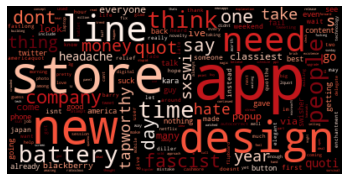

In [1145]:
#generating negative wordcloud for apple products
wordcloud = WordCloud(
    max_font_size=75,
    collocations=False, 
    colormap="Reds")
wordcloud.generate(apple_negative.replace(
    'apple','').replace(
    'ipad','').replace(
    'iphone',''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [1146]:
apple_neg_df[apple_neg_df['text'].str.contains('design')].head(10)

,text,product,text_tokenized,text_without_stopwords,stemmed_text,lemmatized_text,label
3310,ipad design malady ipad elbow i hate the ipad...,Apple,"[ipad, design, malady, ipad, elbow, hate, the,...","[ipad, design, malady, ipad, elbow, hate, ipad...","[ipad, design, maladi, ipad, elbow, hate, ipad...","[ipad, design, malady, ipad, elbow, hate, ipad...",Negative
1886,sxsw ipad design headaches take two tablet and...,Apple,"[sxsw, ipad, design, headaches, take, two, tab...","[ipad, design, headaches, take, two, tablet, c...","[ipad, design, headach, take, two, tablet, cal...","[ipad, design, headache, take, two, tablet, ca...",Negative
7817,guess everyone wanted to design ipad apps for ...,Apple,"[guess, everyone, wanted, to, design, ipad, ap...","[guess, everyone, wanted, design, ipad, apps, ...","[guess, everyon, want, design, ipad, app, mom]","[guess, everyone, wanted, design, ipad, apps, ...",Negative
3818,ipad app getting panned for design trumping c...,Apple,"[ipad, app, getting, panned, for, design, trum...","[ipad, app, getting, panned, design, trumping,...","[ipad, app, get, pan, design, trump, content, ...","[ipad, app, getting, panned, design, trumping,...",Negative
3647,ipad designui tip ûïbuttons are a hack approa...,Apple,"[ipad, designui, tip, ûïbuttons, are, hack, ap...","[ipad, designui, tip, ûïbuttons, hack, approac...","[ipad, designui, tip, ûïbutton, hack, approach...","[ipad, designui, tip, ûïbuttons, hack, approac...",Negative
7540,design for ipad is like a design 101 class wil...,Apple,"[design, for, ipad, is, like, design, 101, cla...","[design, ipad, like, design, 101, class, someo...","[design, ipad, like, design, 101, class, someo...","[design, ipad, like, design, 101, class, someo...",Negative
8355,i just watched quotipad design headachesquot a...,Apple,"[just, watched, quotipad, design, headachesquo...","[watched, quotipad, design, headachesquot, but...","[watch, quotipad, design, headachesquot, butto...","[watched, quotipad, design, headachesquot, but...",Negative
2779,getting ready for quotipad design headachesquo...,Apple,"[getting, ready, for, quotipad, design, headac...","[getting, ready, quotipad, design, headachesquot]","[get, readi, quotipad, design, headachesquot]","[getting, ready, quotipad, design, headachesquot]",Negative
3157,kicking off w talking ipad design headaches sxsw,Apple,"[kicking, off, talking, ipad, design, headache...","[kicking, talking, ipad, design, headaches]","[kick, talk, ipad, design, headach]","[kicking, talking, ipad, design, headache]",Negative
6154,rt ipad design malady ipad elbow i hate the ...,Apple,"[rt, ipad, design, malady, ipad, elbow, hate, ...","[ipad, design, malady, ipad, elbow, hate, ipad...","[ipad, design, maladi, ipad, elbow, hate, ipad...","[ipad, design, malady, ipad, elbow, hate, ipad...",Negative


In [1147]:
print(apple_neg_df.loc[6154, 'text'])

rt  ipad design malady ipad elbow  i hate the ipads back button with the heat of a million suns tapworthy sxsw


Given that this is a retweet, at least two people hate the iPad 2 back button. The design of this product in general seems to have attracted quite a bit of negative attention.

### Postive Google Tweets

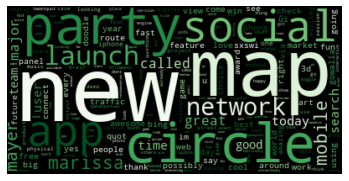

In [1148]:
wordcloud = WordCloud(collocations=False, colormap='Greens').generate(
    google_positive.replace(
        'google', '').replace(
        'android', ''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [1149]:
#marissa is heavily mentioned amoing positive Google-related tweets.
google_pos_df[google_pos_df['text'].str.contains('marissa')].head(10)

,text,product,text_tokenized,text_without_stopwords,stemmed_text,lemmatized_text,label
4867,great demo of google maps from marissa mayer 3...,Google,"[great, demo, of, google, maps, from, marissa,...","[great, demo, google, maps, marissa, mayer, 3d...","[great, demo, googl, map, marissa, mayer, 3d, ...","[great, demo, google, map, marissa, mayer, 3d,...",Positive
4278,googles marissa mayer quotthe mobile phone is ...,Google,"[googles, marissa, mayer, quotthe, mobile, pho...","[googles, marissa, mayer, quotthe, mobile, pho...","[googl, marissa, mayer, quotth, mobil, phone, ...","[google, marissa, mayer, quotthe, mobile, phon...",Positive
7033,marissagoogle sxsw google maps for mobile usin...,Google,"[marissagoogle, sxsw, google, maps, for, mobil...","[marissagoogle, google, maps, mobile, using, v...","[marissagoogl, googl, map, mobil, use, vector,...","[marissagoogle, google, map, mobile, using, ve...",Positive
6292,rt marissa mayer google will connect the digi...,Google,"[rt, marissa, mayer, google, will, connect, th...","[marissa, mayer, google, connect, digital, phy...","[marissa, mayer, googl, connect, digit, physic...","[marissa, mayer, google, connect, digital, phy...",Positive
1037,google is reproducing digitally the way you or...,Google,"[google, is, reproducing, digitally, the, way,...","[google, reproducing, digitally, way, organica...","[googl, reproduc, digit, way, organ, consum, i...","[google, reproducing, digitally, way, organica...",Positive
6295,rt marissa mayer google will connect the digi...,Google,"[rt, marissa, mayer, google, will, connect, th...","[marissa, mayer, google, connect, digital, phy...","[marissa, mayer, googl, connect, digit, physic...","[marissa, mayer, google, connect, digital, phy...",Positive
7477,google maps 50 guys this will be huge google ...,Google,"[google, maps, 50, guys, this, will, be, huge,...","[google, maps, 50, guys, huge, google, marissa...","[googl, map, 50, guy, huge, googl, marissa, ma...","[google, map, 50, guy, huge, google, marissa, ...",Positive
8420,watching the 3d rendering that the google team...,Google,"[watching, the, 3d, rendering, that, the, goog...","[watching, 3d, rendering, google, team, put, t...","[watch, 3d, render, googl, team, put, togeth, ...","[watching, 3d, rendering, google, team, put, t...",Positive
8371,very excited about this marissa mayer of googl...,Google,"[very, excited, about, this, marissa, mayer, o...","[excited, marissa, mayer, google, sxtxstate]","[excit, marissa, mayer, googl, sxtxstate]","[excited, marissa, mayer, google, sxtxstate]",Positive
2221,marissa mayer google wil connect the digital a...,Google,"[marissa, mayer, google, wil, connect, the, di...","[marissa, mayer, google, wil, connect, digital...","[marissa, mayer, googl, wil, connect, digit, p...","[marissa, mayer, google, wil, connect, digital...",Positive


In [1150]:
print(google_pos_df.loc[4867, 'text'])

great demo of google maps from marissa mayer 3d views are amazing more than 150m mobile users sxsw


It looks like Google's Marissa Mayer had a very well received presentation at the conference. Some quick research reveals that she was hired by the company in 1999 as their 20th employee.

### Negative Google Tweets

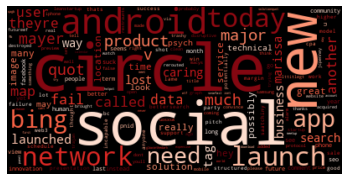

In [1151]:
wordcloud = WordCloud(collocations=False, colormap='Reds').generate(google_negative.replace('google',''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [1152]:
#circle was featured heavily in both positive and negative tweets
google_neg_df[google_neg_df['text'].str.contains('circle')].head(10)

,text,product,text_tokenized,text_without_stopwords,stemmed_text,lemmatized_text,label
1345,just when you thought quotsocialquot couldnt g...,Google,"[just, when, you, thought, quotsocialquot, cou...","[thought, quotsocialquot, couldnt, get, overbl...","[thought, quotsocialquot, couldnt, get, overbl...","[thought, quotsocialquot, couldnt, get, overbl...",Negative
4238,after failure of google buzz google latitude n...,Google,"[after, failure, of, google, buzz, google, lat...","[failure, google, buzz, google, latitude, goog...","[failur, googl, buzz, googl, latitud, googl, c...","[failure, google, buzz, google, latitude, goog...",Negative
3330,google circles will be lame sxsw lt3,Google,"[google, circles, will, be, lame, sxsw, lt3]","[google, circles, lame, lt3]","[googl, circl, lame, lt3]","[google, circle, lame, lt3]",Negative
6021,rt hm do we need another 1 rt google to laun...,Google,"[rt, hm, do, we, need, another, rt, google, to...","[hm, need, another, google, launch, major, new...","[hm, need, anoth, googl, launch, major, new, s...","[hm, need, another, google, launch, major, new...",Negative
4375,nope seems no google circles launch today link...,Google,"[nope, seems, no, google, circles, launch, tod...","[nope, seems, google, circles, launch, today]","[nope, seem, googl, circl, launch, today]","[nope, seems, google, circle, launch, today]",Negative
6482,rt rt to launch major new social network c...,Google,"[rt, rt, to, launch, major, new, social, netwo...","[launch, major, new, social, network, called, ...","[launch, major, new, social, network, call, ci...","[launch, major, new, social, network, called, ...",Negative
5710,rt false alarm google circles not coming now ...,Google,"[rt, false, alarm, google, circles, not, comin...","[false, alarm, google, circles, coming, probab...","[fals, alarm, googl, circl, come, probabl, eve...","[false, alarm, google, circle, coming, probabl...",Negative
7574,google circles is not a real thing and will no...,Google,"[google, circles, is, not, real, thing, and, w...","[google, circles, real, thing, launched, today]","[googl, circl, real, thing, launch, today]","[google, circle, real, thing, launched, today]",Negative
4193,and it will suck rt rt google will preview m...,Google,"[and, it, will, suck, rt, rt, google, will, pr...","[suck, google, preview, major, new, social, se...","[suck, googl, preview, major, new, social, ser...","[suck, google, preview, major, new, social, se...",Negative
7996,circles set to fail for being too complicated ...,Google,"[circles, set, to, fail, for, being, too, comp...","[circles, set, fail, complicated, june, google...","[circl, set, fail, complic, june, googl, set, ...","[circle, set, fail, complicated, june, google,...",Negative


In [1153]:
print(google_neg_df.loc[7574, 'text'])

google circles is not a real thing and will not be launched today at sxsw link


Apparently, a social networkd called Circles was supposed to be launched at the conference, but the launch never occured. That explains the split in sentiment. There also seemed to be mixed opinions as to how good it would be prior to the launch being canceled. 

## Modeling Data
Now that we have shown the insight that can quickly be pulled from the data, we need to build a classification model that can detect the sentiment of tweets with a reasonable level of accuracy. A Multinomial Naive Bayes model is one of the leading algorithms for language processing. We will apply it to our unprocessed data as a baseline model and then decide which direction to go from there.

In [1154]:
#We will use a low number of max_features for our baseline model
tfidf = TfidfVectorizer(max_features=20)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['text'])
X_test_vectorized = tfidf.fit_transform(X_test['text'])

In [1155]:
baseline_model = MultinomialNB()
baseline_train = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_model.fit(X_train_vectorized, y_train)
test_score = baseline_model.score(X_test_vectorized, y_test)
print('train scores:', baseline_train.mean())
print('test scores:', test_score)

train scores: 0.6029543557380881
test scores: 0.6029543419874664


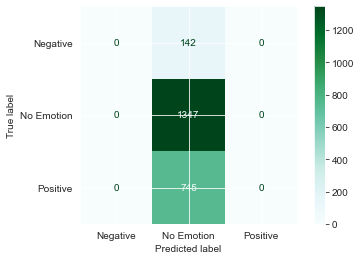

In [1156]:
plot_confusion_matrix(baseline_model, test_stem_vectorized, y_test, cmap='BuGn');

### Baseline Model Performance
While the accuracy score for our baseline seems okay at face value, the confusion matrix shows that the model is simply predicting "no emotion" for every tweet. 

In [1169]:
X_train['final_lem_text'] = X_train['lemmatized_text'].apply(lambda x: ' '.join(x))
X_train['final_stem_text'] = X_train['stemmed_text'].apply(lambda x: ' '.join(x))

In [1170]:
tfidf = TfidfVectorizer(max_features=20)

# Fit the vectorizer on X_train["text"] and transform it
train_lem_vectorized = tfidf.fit_transform(X_train["final_lem_text"])
train_stem_vectorized = tfidf.fit_transform(X_train['final_stem_text'])

In [1171]:
untuned = MultinomialNB()
lemmatized_cv = cross_val_score(untuned, train_lem_vectorized, y_train)
print("lemmatized train cv scores:", lemmatized_cv.mean())
stemmed_cv = cross_val_score(untuned, train_stem_vectorized, y_train)
print("stemmed train cv scores:" ,stemmed_cv.mean())

lemmatized train cv scores: 0.6060869032911506
stemmed train cv scores: 0.6075796632052266


### Stemming vs. Lemmatizing
The snowball stemmer is yielding slightly better training scores than the lemmatizer, so we will apply this to the test data as well.

In [1172]:
#stemming test data 
tfidf = TfidfVectorizer(max_features=20)

X_test['stemmed_text'] = X_test['text_without_stopwords'].apply(stem_text)
X_test['final_text'] = X_test['stemmed_text'].apply(lambda x: ' '.join(x))
test_stem_vectorized = tfidf.fit_transform(X_test['final_text'])

In [1173]:
untuned.fit(train_stem_vectorized, y_train)
untuned.score(train_stem_vectorized, y_train)
untuned.score(test_stem_vectorized, y_test)

0.6047448522829006

Stemming seems to have improved accuracy for the test data as well. 

In [1174]:
untuned.fit(train_stem_vectorized, y_train)
y_pred = untuned.predict(test_stem_vectorized)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
  No Emotion       0.99      0.61      0.75      2185
    Positive       0.03      0.43      0.05        49

    accuracy                           0.60      2234
   macro avg       0.34      0.35      0.27      2234
weighted avg       0.97      0.60      0.74      2234



In general, these scores are a little bit higher than our baseline model. 

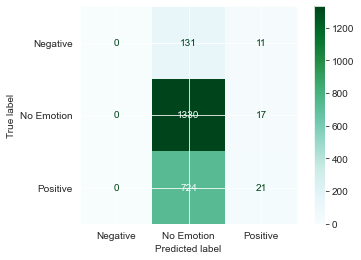

In [1175]:
plot_confusion_matrix(untuned, test_stem_vectorized, y_test, cmap='BuGn');

### Stemmed Model Performance
Unsurprisingly, the biggest issue continues to be classifying negative and positive sentiments (our minority classes). The AdaBoost classifier is quite popular and tends to do a good job with imbalanced data. Additionally, we should shift focus toward f1 scores rather than accuracy for final model tuning. Both false positives and false negatives are detrimental to the usefulness of our final deliverables.

In [1177]:
model_ad = AdaBoostClassifier(random_state = 7)
stemmed_cv = cross_val_score(model_ad, train_stem_vectorized, y_train)
model_ad.fit(train_stem_vectorized , y_train)
y_pred = model_ad.predict(test_stem_vectorized)
print(classification_report(y_test, y_pred))
print("training score:", stemmed_cv.mean())

              precision    recall  f1-score   support

    Negative       0.17      0.02      0.04       142
  No Emotion       0.62      0.93      0.74      1347
    Positive       0.43      0.11      0.17       745

    accuracy                           0.60      2234
   macro avg       0.41      0.35      0.32      2234
weighted avg       0.53      0.60      0.51      2234

training score: 0.6077316994446115


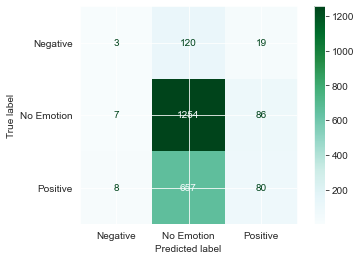

In [1178]:
plot_confusion_matrix(model_ad, test_stem_vectorized, y_test, cmap='BuGn');

### Untuned AdaBoost Model Performance
These scores still aren't amazing but at least we are properly classifying some negative tweets. Before tuning the model, let's try increasing the number of features when lemmatizing.

In [1166]:
tfidf= TfidfVectorizer(max_features=100)
train_stem_vectorized_100 = tfidf.fit_transform(X_train['final_stem_text'])
test_stem_vectorized_100 = tfidf.fit_transform(X_test['final_text'])

model_ad = AdaBoostClassifier(random_state = 7)
stemmed_cv = cross_val_score(model_ad, train_stem_vectorized_100, y_train)
model_ad.fit(train_stem_vectorized_100 , y_train)
y_pred = model_ad.predict(test_stem_vectorized_100)
print(classification_report(y_test, y_pred))
print("training score:", stemmed_cv.mean())

              precision    recall  f1-score   support

    Negative       0.14      0.01      0.03       142
  No Emotion       0.62      0.89      0.73      1347
    Positive       0.47      0.19      0.27       745

    accuracy                           0.60      2234
   macro avg       0.41      0.36      0.34      2234
weighted avg       0.54      0.60      0.53      2234

training score: 0.6230975992520619


### Increased Vectorizer Features
This improved our f1 score for positive sentiment tweets, but hindered it for the other categories.

## Model Tuning
We will continue with a 20 feature vectorizer and tune the parameters of the AdaBoost model.

In [1179]:
#grid search parameters for the AdaBoost classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

paramgrid = {'base_estimator__min_samples_split':[2,4,6,8],
         'base_estimator__min_samples_leaf':[1,2,3],
         'base_estimator__max_depth':[1,2,3],'n_estimators': [50,100,150,200],'learning_rate':[0.01,0.1]}

R=GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),paramgrid,cv = 3,scoring='f1')

R.fit(train_stem_vectorized,y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'base_estimator__min_samples_leaf': [1, 2, 3],
                         'base_estimator__min_samples_split': [2, 4, 6, 8],
                         'learning_rate': [0.01, 0.1],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1')

In [1180]:
R.best_params_

{'base_estimator__max_depth': 1,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'learning_rate': 0.01,
 'n_estimators': 50}

In [1181]:
#Fitting a tuned AdaBoost Classifier

tuned_adb = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(
                               max_depth = 1,
                               min_samples_leaf=1, 
                               min_samples_split=2), 
                               learning_rate = 0.01, 
                               n_estimators=50)
tuned_adb.fit(train_stem_vectorized, y_train)
tuned_adb.score(test_stem_vectorized, y_test)


0.6042972247090421

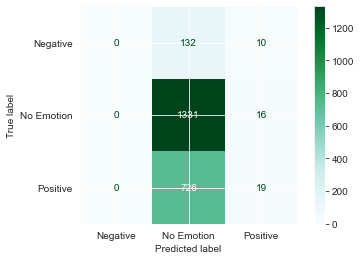

In [1182]:
plot_confusion_matrix(tuned_adb, test_stem_vectorized, y_test, cmap='BuGn');

### Tuned AdaBoost Performance
It seems that by tuning our model, we have effectively reintroduced that same issues that affected our baseline. For now we will settle with an untuned AdaBoost classifier until we are able to obtain more examples of negative sentiment text to train our model on.

## Next Steps
1) The model needs more examples of the minority classes. We could build a binary classifier and train it only on the minorty classes, find more examples of negative and positive tweets, or experiement with other parameters of our model.

2) This model needs to be tested on other subjects. In order for it to be useful it needs to be able to classify text regardless of subject matter.

3) It would be helpful to obtain more recent data, or to see how this model performs on tweets about the conference in subsequent years.

## Recommendations 
Based on my findings on this project I would recommend the following:

1) This tool should be used as demonstrated in this notebook, first looking at overall sentiment, then frequent words in the dataset as a whole, then word clouds, then individual tweets. This helps develop an overall understanding of the subject while quickly zeroing in on examples of individual issues/opinions.

2) Specific to this dataset, a story about the 2012 SXSW festival might look into the failed launch of Circles. 

3) Additionally an article breaking down the positives and negatives of the new iPad 2 would be of interest for potential buyers.

3) Marissa Mayer seems to have given a very quotable presentation. If writing about the festival as a whole, her presence there seemed to be a major highlight for Google.